# <a name="setup_section"></a> 1. Setup: Manage Installations Imports and Helper Functions


In [1]:
#!pip install --upgrade GPy
#!pip install --upgrade numpy

In [2]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import csv
import GPy
import numpy as np

from datetime import datetime
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from scipy.stats import norm, percentileofscore

warning in stationary: failed to import cython module: falling back to numpy
warning in coregionalize: failed to import cython module: falling back to numpy
warning in choleskies: failed to import cython module: falling back to numpy


# <a name="loading_datasets"></a> 2. Loading Datasets


## Load metadata


In [3]:
metdata_path = "..\\data\\metadata\\"
metadata = pd.read_csv(metdata_path + "metadata.csv")


## Load weather data

In [4]:
# Weather data
weather_path = "..\\data\\weather\\"
weather = pd.read_csv(weather_path + "weather.csv")

In [5]:
weather.head()

timestamp  site_id  airTemperature  cloudCoverage  \
0  2016-01-01 00:00:00  Panther            19.4            NaN   
1  2016-01-01 01:00:00  Panther            21.1            6.0   
2  2016-01-01 02:00:00  Panther            21.1            NaN   
3  2016-01-01 03:00:00  Panther            20.6            NaN   
4  2016-01-01 04:00:00  Panther            21.1            NaN   

   dewTemperature  precipDepth1HR  precipDepth6HR  seaLvlPressure  \
0            19.4             0.0             NaN             NaN   
1            21.1            -1.0             NaN          1019.4   
2            21.1             0.0             NaN          1018.8   
3            20.0             0.0             NaN          1018.1   
4            20.6             0.0             NaN          1019.0   

   windDirection  windSpeed  
0            0.0        0.0  
1            0.0        0.0  
2          210.0        1.5  
3            0.0        0.0  
4          290.0        1.5


## Load raw dataset

In [6]:
raw_meters_path = "..\\data\\meters\\raw\\"

# files in directory
files = glob(raw_meters_path + "*.csv")

In [7]:

dfs = [] # empty list of the dataframes to create
for file in files: # for each file in directory
    meter_type = file.split("\\")[4].split(".")[0] # meter_type to rename the value feature
    meter = pd.read_csv(file) # load the dataset
    meter = pd.melt(meter, id_vars = "timestamp", var_name = "building_id", value_name = "meter_reading") # melt dataset
    meter["meter"] = str(meter_type) # adds column with the meter type
    dfs.append(meter) # append to list
raw_data_cleaned = pd.concat(dfs, axis=0, ignore_index=True) # concatenate all meter
del(dfs, meter, file, files, meter_type)

raw_data_cleaned.head()


timestamp                building_id  meter_reading         meter
0  2016-01-01 00:00:00  Panther_office_Clementine            NaN  chilledwater
1  2016-01-01 01:00:00  Panther_office_Clementine            NaN  chilledwater
2  2016-01-01 02:00:00  Panther_office_Clementine            NaN  chilledwater
3  2016-01-01 03:00:00  Panther_office_Clementine            NaN  chilledwater
4  2016-01-01 04:00:00  Panther_office_Clementine            NaN  chilledwater

## Load cleaned dataset


In [8]:
cleaned_meters_path = "..\\data\\meters\\cleaned\\"

# files in directory
files = glob(cleaned_meters_path + "*.csv")


In [9]:
dfs = [] # empty list of the dataframes to create
for file in files: # for each file in directory
    meter_type = file.split("\\")[4].split(".")[0] # meter_type to rename the value feature
    meter = pd.read_csv(file) # load the dataset
    meter = pd.melt(meter, id_vars = "timestamp", var_name = "building_id", value_name = "meter_reading") # melt dataset
    meter["meter"] = str(meter_type) # adds column with the meter type
    dfs.append(meter) # append to list
complete_data_cleaned = pd.concat(dfs, axis=0, ignore_index=True) # concatenate all meter
del(dfs, meter, file, files, meter_type)

complete_data_cleaned.head()


timestamp                building_id  meter_reading  \
0  2016-01-01 00:00:00  Panther_office_Clementine            NaN   
1  2016-01-01 01:00:00  Panther_office_Clementine            NaN   
2  2016-01-01 02:00:00  Panther_office_Clementine            NaN   
3  2016-01-01 03:00:00  Panther_office_Clementine            NaN   
4  2016-01-01 04:00:00  Panther_office_Clementine            NaN   

                  meter  
0  chilledwater_cleaned  
1  chilledwater_cleaned  
2  chilledwater_cleaned  
3  chilledwater_cleaned  
4  chilledwater_cleaned

In [10]:
# Note this cell might take some time to finish

# Convert timestamp field from string into pd.datetime object
complete_data_cleaned['timestamp'] = pd.to_datetime(complete_data_cleaned['timestamp'])

# Add column indicating the year, month and dayOfTheWeek for that timestamp
complete_data_cleaned['date'] = complete_data_cleaned['timestamp'].dt.date
complete_data_cleaned['year'] = complete_data_cleaned['timestamp'].dt.year
complete_data_cleaned['month'] = complete_data_cleaned['timestamp'].dt.month
complete_data_cleaned['dayOfWekk'] = complete_data_cleaned['timestamp'].dt.dayofweek


# Load benchmarks


In [11]:
cleaned_meters_path = "..\\data\\"

# files in directory
files = glob(cleaned_meters_path + "*.csv")


benchmark = pd.read_csv(files[0]) # load the dataset

benchmark

name building_id       RMSE        MAE horizon
0        Bear_utility_Sidney     utility   1.157131   0.846614  hourly
1        Bear_utility_Sidney     utility   1.255013   0.862390   daily
2        Bear_utility_Sidney     utility   1.851878   1.167219  weekly
3   Cockatoo_religion_Diedre    religion   1.475301   1.018945  hourly
4   Cockatoo_religion_Diedre    religion   2.349360   1.820794   daily
5   Cockatoo_religion_Diedre    religion   2.833513   1.958076  weekly
6       Cockatoo_science_Rex     science   7.304536   5.529282  hourly
7       Cockatoo_science_Rex     science  10.882962   7.975783   daily
8       Cockatoo_science_Rex     science  12.667458   8.261340  weekly
9     Eagle_education_Teresa   education   8.286079   5.855556  hourly
10    Eagle_education_Teresa   education  11.534440   8.819952   daily
11    Eagle_education_Teresa   education  14.939611  10.992661  weekly
12      Eagle_health_Lucinda      health  24.377798  14.279867  hourly
13      Eagle_health_Lucinda      health  40.084198  28.209270   daily
14      Eagle_health_Lucinda      health  50.877437  35.407537  weekly
15        Fox_food_Francesco        food   9.409997   6.518361  hourly
16        Fox_food_Francesco        food  10.331829   7.536682   daily
17        Fox_food_Francesco        food  18.896017  10.796031  weekly
18        Fox_parking_Tommie     parking   2.536276   1.177474  hourly
19        Fox_parking_Tommie     parking   3.155471   1.812750   daily
20        Fox_parking_Tommie     parking   3.463871   1.573460  weekly
21      Gator_other_Gertrude       other   0.232520   0.051120  hourly
22      Gator_other_Gertrude       other   1.070888   0.786288   daily
23      Gator_other_Gertrude       other   1.404810   0.946556  weekly
24           Hog_office_Bill      office  18.614739  10.711040  hourly
25           Hog_office_Bill      office  46.933820  29.432126   daily
26           Hog_office_Bill      office  60.590159  34.006334  weekly
27       Hog_services_Kerrie    services   2.075842   1.448992  hourly
28       Hog_services_Kerrie    services   3.061034   2.400821   daily
29       Hog_services_Kerrie    services   3.818607   2.549373  weekly
30      Hog_warehouse_Porsha   warehouse   1.958354   0.945058  hourly
31      Hog_warehouse_Porsha   warehouse   2.141530   1.150929   daily
32      Hog_warehouse_Porsha   warehouse   2.911756   1.397100  weekly
33      Lamb_assembly_Bertie    assembly  17.967060  10.985065  hourly
34      Lamb_assembly_Bertie    assembly  28.582859  22.667979   daily
35      Lamb_assembly_Bertie    assembly  48.756165  28.608991  weekly
36     Lamb_industrial_Carla  industrial  45.353234  30.321867  hourly
37     Lamb_industrial_Carla  industrial  43.913538  31.891065   daily
38     Lamb_industrial_Carla  industrial  53.681570  26.884887  weekly
39   Peacock_lodging_Matthew     lodging   3.862391   2.968328  hourly
40   Peacock_lodging_Matthew     lodging   4.518313   3.510761   daily
41   Peacock_lodging_Matthew     lodging   8.428719   6.074870  weekly
42        Rat_public_Loretta      public   2.925038   1.817659  hourly
43        Rat_public_Loretta      public   9.891990   6.787990   daily
44        Rat_public_Loretta      public  16.948175  12.082286  weekly
45      Wolf_retail_Marcella      retail   1.187043   0.793767  hourly
46      Wolf_retail_Marcella      retail   1.857042   1.375036   daily
47      Wolf_retail_Marcella      retail   3.254573   2.155485  weekly

In [22]:
buildingIds = benchmark['name'].unique()

# Gaussian Process Regression

## Implement Helper Functions

In [12]:
"""
Normalizes the data to a Gaussian distribution using quantiles.
"""
def normalizeToGaussian(arr, mode="mean"):
    n = len(arr)
    perc = percentileofscore
    arr_ = arr.copy()[~np.isnan(arr)]
    out = np.zeros(n)
    for i in range(n):
        if not np.isnan(arr[i]):
            out[i] = norm.ppf(perc(arr_, arr[i], mode) / 100.)
        else:
            out[i] = np.nan
    return out


In [13]:
'''
Function that transforms the Gaussian normalisation back to percentiles of scores
'''
def gaussianToCdf(arr):
    n = len(arr)
    out = np.zeros(n)
    for i in range(n):
        if not np.isnan(arr[i]):
            out[i] = norm.cdf(arr[i])
        else:
            out[i] = np.nan
            
    out = out
    
    return out

In [14]:
def transformIntoOriginalRange(arr, original):

    
    original_min = np.min(original)
    original_max = np.max(original)
    original_mean = np.nanmean(original) 
    original_std = np.nanstd(original)

    # Calculate the range, mean, and standard deviation of the predictions
    arr_range = np.max(arr) - np.min(arr)
    arr_mean = np.mean(arr)
    arr_std = np.std(arr)

    # Rescale the predictions based on the original signal's range and statistics
    rescaled = (
        (arr - arr_mean) * (original_std / arr_std) + original_mean
    )

    # Adjust the rescaled predictions to fit within the original signal's range
    min_diff = original_min - np.min(rescaled)
    max_diff = np.max(rescaled) - original_max
    if min_diff > 0:
        rescaled -= min_diff
    elif max_diff > 0:
        rescaled -= max_diff
 
    return rescaled

In [15]:
'''
Replaces missing values in the dataframe with the mean of the month for all years from which we have data
@param dataframe
@returns numpy array
'''
def averageNaNs (df, field):
    mean_df = df.groupby(['month']).mean()
    averaged_mean = df[field].copy().fillna(df['month'].map({1: mean_df[field][1] , 2: mean_df[field][2], 3:mean_df[field][3],
                                                    4: mean_df[field][4] , 5: mean_df[field][5], 6:mean_df[field][6], 
                                                    7: mean_df[field][7] , 8: mean_df[field][8], 9:mean_df[field][9],
                                                    10: mean_df[field][10] , 11: mean_df[field][11], 12:mean_df[field][12]}))
    
    averaged_numpy = averaged_mean.to_numpy()
    return averaged_numpy

In [16]:
'''
Train a Gaussian Process model based on the training data
@param two numpy arrays of same dimensionality
@returns numpy array with lenght NUMBER_OF_DIMENSIONS, containing the indices of the most correlated stations
'''
def trainGP (X_train, Y_train):
    
    # Shape of training data needs to be consistent 
    assert X_train.shape[0] == Y_train.shape[0]
    
    kernel = GPy.kern.RBF(input_dim=X_train.shape[1])
    model = GPy.models.GPRegression(X_train, Y_train, kernel)
    model.optimize(messages=True)
    model.optimize_restarts(num_restarts=10)
    
    return model

# So far unused helper functions

In [17]:
'''
Computation of Spearmas Rank Correlation
@param  target_df: a pandas.dataframe (target) for wich we want to calculate the correlation matrix 
        dataset: a list of pandas dataframes that build our base, as we check for the correlation between dataframe and each df in the truncated dataset
@returns spearmans_matrix: a numpy.ndarray that contains the correlation value as first entry in each row and the corresponding p-value as a second element in each row. 
                            the order of stations in the matrix is consistent to the order in the dataset:
'''
def spearmansCorrelation (target_df, truncated_dataset): 
    spearmans_matrix = np.zeros((len(truncated_dataset), 2))
    for index, df in enumerate(truncated_dataset): 
        if (target_df.shape[0]!= df.shape[0]) or (df['MEAN'].isnull().all()):
            spearmans_matrix[index] = 0,100 
            continue
        else: 
            correlation, pval = stats.spearmanr(target_df['MEAN'], df['MEAN'], nan_policy='omit')
            spearmans_matrix[index] = correlation,pval    
            
    return spearmans_matrix

### Load dataframe

In [18]:
# Convert timestamp field from string into pd.datetime object
weather['timestamp'] = pd.to_datetime(weather['timestamp'])

# Add column indicating the year, month and dayOfTheWeek for that timestamp
weather['date'] = weather['timestamp'].dt.date
weather['month'] = weather['timestamp'].dt.month

In [19]:
# Convert timestamp field from string into pd.datetime object
complete_data_cleaned['timestamp'] = pd.to_datetime(complete_data_cleaned['timestamp'])

# Add column indicating the year, month and dayOfTheWeek for that timestamp
complete_data_cleaned['date'] = pd.to_datetime(complete_data_cleaned['timestamp']).dt.date
complete_data_cleaned['year'] = pd.to_datetime(complete_data_cleaned['timestamp']).dt.year
complete_data_cleaned['month'] = pd.to_datetime(complete_data_cleaned['timestamp']).dt.month
complete_data_cleaned['dayOfWeek'] = complete_data_cleaned['timestamp'].dt.dayofweek


In [20]:
# Find the dataframe that matches our building_id
bear_sidney = complete_data_cleaned.loc[complete_data_cleaned['building_id']  == 'Bear_utility_Sidney']

# For later reconstruction we split the original meter reading into train and test
original_data_train, original_data_test = train_test_split(bear_sidney['meter_reading'], test_size=0.3, shuffle=False)

# Load the meta data for the given building_id
bear_sidney_meta = metadata.loc[metadata['building_id'] == 'Bear_utility_Sidney']

# load the weather data for the location 
bear_weather = weather.loc[weather['site_id'] == 'Bear']

### Transform into Gaussian

In [21]:
bear_sidney_gauss = normalizeToGaussian(averageNaNs(bear_sidney, 'meter_reading'))

In [23]:
bear_sidney_weather_air_temp = normalizeToGaussian(averageNaNs(bear_weather,'airTemperature'))
bear_sidney_weather_dew_temp = normalizeToGaussian(averageNaNs(bear_weather,'dewTemperature'))
bear_sidney_weather_precip_1HR = normalizeToGaussian(averageNaNs(bear_weather,'precipDepth1HR'))

### Split into train and test sets

In [24]:
train_meter, test_meter = train_test_split(bear_sidney_gauss, test_size=0.3, shuffle=False)
train_weather_air_temp, test_weather_air_temp = train_test_split(bear_sidney_weather_air_temp, test_size=0.3, shuffle=False)
train_weather_dew_temp, test_weather_dew_temp = train_test_split(bear_sidney_weather_dew_temp, test_size=0.3, shuffle=False)
train_weather_precip_1HR, test_weather_precip_1HR = train_test_split(bear_sidney_weather_precip_1HR, test_size=0.3, shuffle=False)

In [26]:
X_train = np.column_stack(([train_weather_air_temp, train_weather_dew_temp, train_weather_precip_1HR]))
X_test = np.column_stack(([test_weather_air_temp, test_weather_dew_temp, test_weather_precip_1HR]))

## Specify and Train Gaussian Process model

In [27]:
# Specify the kernel: Radial basis function kernel (RBF)
kernel = GPy.kern.RBF(input_dim=X_train.shape[1])  

# Create a GP Regression model
model = GPy.models.GPRegression(X_train[-3000:], train_meter[-3000:].reshape(-1,1), kernel)

# Optimize model parameters
model.optimize(messages=True)

In [28]:
# Make predictions with the trained model
mean, var = model.predict(X_test[0:200])

###### Plot the results given driectly from the GP

Note as we previously transformed the data to be normal distributed, the data we obtain here is as well transformed <br>
In order to reconstruct the original data we need to transform it back

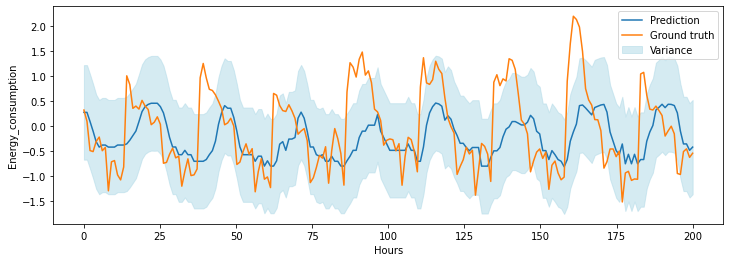

In [29]:
x = np.linspace(0, np.size(mean), np.size(mean))

plt.figure(figsize=(12,4))
plt.xlabel('Hours')
plt.ylabel('Energy_consumption')

plt.plot(x, mean, label='Prediction')
plt.plot(x, test_meter[0:200], label='Ground truth')
plt.fill_between(x, (mean - var).flatten(), (mean + var).flatten(), color='lightblue', alpha=0.5, label='Variance')
plt.legend()
plt.show()

## Convert the results back and compare the results

In [31]:
prediction_transformed = transformIntoOriginalRange(mean.flatten(), original_data_train)
variance_transformed = transformIntoOriginalRange(var.flatten(), original_data_train)
original_test_transformed = transformIntoOriginalRange(original_data_test[0:200], original_data_train)

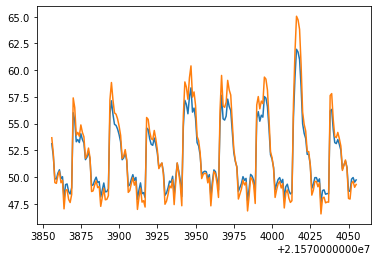

In [36]:
plt.plot(original_data_test[0:200])
plt.plot(original_test_transformed)

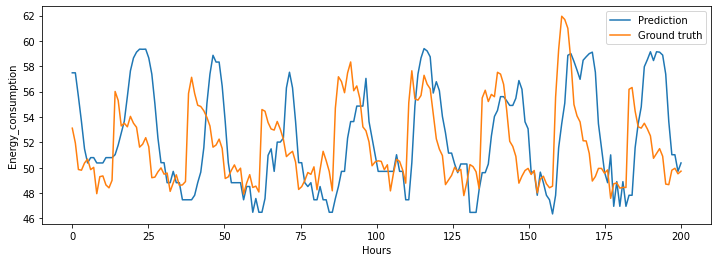

In [42]:
x = np.linspace(0, np.size(prediction_transformed), np.size(prediction_transformed))

plt.figure(figsize=(12,4))
plt.xlabel('Hours')
plt.ylabel('Energy_consumption')

plt.plot(x, prediction_transformed, label='Prediction')
plt.plot(x, original_data_test[0:200], label='Ground truth')
plt.legend()
plt.show()

# Error computation

In [45]:
mse = mean_squared_error(original_data_test[0:200], prediction_transformed)
rmse = np.sqrt(mse)
mae = mean_absolute_error(original_data_test[0:200], prediction_transformed)

print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE", mae)

MSE:  17.431229363926832
RMSE:  4.175072378286014
MAE 3.214666504598467
